# Условие

Обучить бинарный классификатор на основе сверточных нейронных сетей для датасета.
- Вы вольны выбирать любое количество слоёв, подбирать гиперпараметры, выбирать оптимизатор, функцию ошибки итд.    
- Можете разбивать на train-val-test исходя из того, как думаете, что будет лучше.

4 балла:
- Модель должна работоспособна, воспроизводима, код должен быть читаемым;
- Метрика качества accuracy должна быть не ниже 0.9;
- Процесс схождения должен быть залогирован (хотя бы просто графиками в matplotlib, но желательно втч. и в Tensorboard/ClearML/...).

5 баллов:
- Всё то же самое, что на 4 балла, но выполнены подзадания 1, 2 и 3, а метрика качества accuracy должна быть не ниже 0.95.



Подзадания:
1) Выведите кол-во обучаемых параметров сети;    
2) Напишите несколько предложений выводов - что помогло в решении и повысило качество, что нет.    
3) Посчитайте F1-score на тестовой подвыборке.

По желанию к выполнению, в разбалловке не учитывается:     
3) Выведите confusion matrix для тестовой подвыборки;    

# Особенности

У меня все выполнялось на cpu

# Домашняя работа

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import time
import sklearn
import PIL
from matplotlib import cm

import torch
import torch.nn as nn
import torch.optim as optim
from torch import no_grad, max, device, cuda
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import TensorDataset, DataLoader, random_split

import os
from tqdm import tqdm
import progressbar
from torch.utils.tensorboard import SummaryWriter

import layers as l # Results from hw1 + hw2

import warnings
warnings.filterwarnings('ignore')

In [2]:
DEVICE = device("cuda:0" if cuda.is_available() else "cpu")

In [3]:
SHAPE = 128

In [12]:
data_dir = './indoor_outdoor_dataset/'

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize([SHAPE, SHAPE]),
    transforms.ToTensor(),           
    transforms.Normalize(mean=[0.5],# 0.5, 0.5],
                         std=[0.5])#, 0.5, 0.5])  
])

full_data = ImageFolder(data_dir, transform=transform)

train_size = int(0.01 * len(full_data))
test_size = int(0.001 * len(full_data))
del_size = len(full_data) - train_size - test_size

train_data, test_data, x = random_split(full_data, [train_size, test_size, del_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [13]:
print(f'''train_size = {train_size}; test_size = {test_size}''')

train_size = 4105; test_size = 410


In [14]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

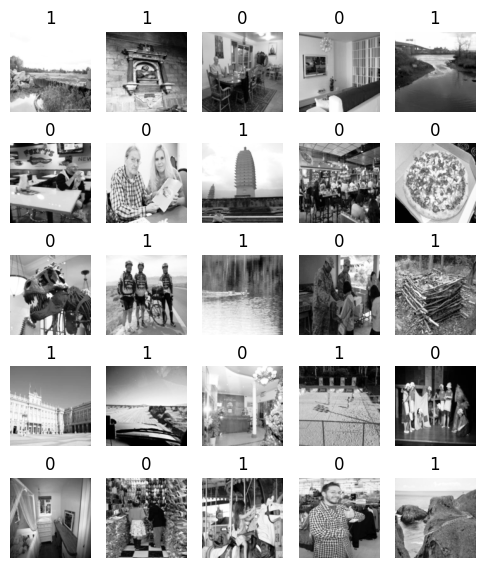

In [15]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(SHAPE, SHAPE), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [8]:
LEARNING_RATE = 0.01
EPOCH = 10

In [35]:
def train(model, criterion, optimizer, num_epochs=EPOCH, train_loader=train_loader, val_loader=test_loader,):
    best_val_acc = 0.0
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []  

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE).float().view(-1, 1)

            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)

        train_loss_epochs.append(train_loss)
        train_accuracy_epochs.append(train_acc)
        test_loss_epochs.append(val_loss)
        test_accuracy_epochs.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, '
              f'Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.4f}, ',
              f't {(time.time() - start_time):.4f} s')
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE).float().view(-1, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    loss = running_loss / len(loader)
    accuracy = correct / total
    return loss, accuracy

In [182]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4096 , 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

mnn = NeuralNetwork()
criterion = nn.BCELoss()
optimizer = optim.Adam(mnn.parameters(), lr=LEARNING_RATE)
train(mnn, criterion, optimizer, train_loader=train_loader, val_loader=test_loader)

Epoch [1/10], Loss: 54.0871, Accuracy: 0.4572, Test Loss: 56.2227, Test Accuracy: 0.4341,  t 23.0274 s
Epoch [2/10], Loss: 56.5972, Accuracy: 0.4334, Test Loss: 56.0976, Test Accuracy: 0.4390,  t 21.3940 s
Epoch [3/10], Loss: 55.9318, Accuracy: 0.4407, Test Loss: 56.0976, Test Accuracy: 0.4390,  t 20.6464 s
Epoch [4/10], Loss: 55.9318, Accuracy: 0.4407, Test Loss: 56.0976, Test Accuracy: 0.4390,  t 21.1129 s
Epoch [5/10], Loss: 55.9318, Accuracy: 0.4407, Test Loss: 56.0976, Test Accuracy: 0.4390,  t 21.3973 s


KeyboardInterrupt: 

In [25]:
def train(network, epochs, learning_rate, loss=None):    
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    for epoch in range(epochs):
        start_time = time.time()
        losses = []
        accuracies = []
        for X, y in train_loader:
            X = X.view(X.shape[0], -1).numpy()
            y = y.numpy()
    
            prediction = network.forward(X)
            loss_batch = loss.forward(prediction, y)
            losses.append(loss_batch)

            dLdx = loss.backward()
            network.backward(dLdx)
            network.step(learning_rate)
            accuracies.append((np.argmax(prediction, 1)==y).mean())
        train_loss_epochs.append(np.mean(losses))
        train_accuracy_epochs.append(np.mean(accuracies))

        '''
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
        '''
        test_loss_epochs.append(0) #np.mean(losses))
        test_accuracy_epochs.append(0) #np.mean(accuracies))
            
        print(
            '\rEpoch [{0}/{1}] (Train/Test) NLL: {2:.3f}/{3:.3f}, Accuracy: {4:.3f}/{5:.3f} t: {6:.4f} s'.format(
                (epoch+1), epochs, train_loss_epochs[-1], test_loss_epochs[-1],
                train_accuracy_epochs[-1], test_accuracy_epochs[-1], (time.time() - start_time))
        )
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

    return train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs

Epoch [1/20] (Train/Test) NLL: 0.648/0.000, Accuracy: 0.616/0.000 t: 8.5288 s
Epoch [2/20] (Train/Test) NLL: 0.620/0.000, Accuracy: 0.642/0.000 t: 8.5290 s
Epoch [3/20] (Train/Test) NLL: 0.600/0.000, Accuracy: 0.661/0.000 t: 8.6653 s
Epoch [4/20] (Train/Test) NLL: 0.577/0.000, Accuracy: 0.683/0.000 t: 8.6433 s
Epoch [5/20] (Train/Test) NLL: 0.552/0.000, Accuracy: 0.711/0.000 t: 8.6393 s
Epoch [6/20] (Train/Test) NLL: 0.521/0.000, Accuracy: 0.738/0.000 t: 8.7035 s
Epoch [7/20] (Train/Test) NLL: 0.497/0.000, Accuracy: 0.762/0.000 t: 8.8199 s
Epoch [8/20] (Train/Test) NLL: 0.453/0.000, Accuracy: 0.802/0.000 t: 8.6505 s
Epoch [9/20] (Train/Test) NLL: 0.418/0.000, Accuracy: 0.828/0.000 t: 8.5216 s
Epoch [10/20] (Train/Test) NLL: 0.390/0.000, Accuracy: 0.843/0.000 t: 8.7403 s
Epoch [11/20] (Train/Test) NLL: 0.361/0.000, Accuracy: 0.861/0.000 t: 8.5234 s
Epoch [12/20] (Train/Test) NLL: 0.329/0.000, Accuracy: 0.883/0.000 t: 8.5698 s
Epoch [13/20] (Train/Test) NLL: 0.280/0.000, Accuracy: 0.904/

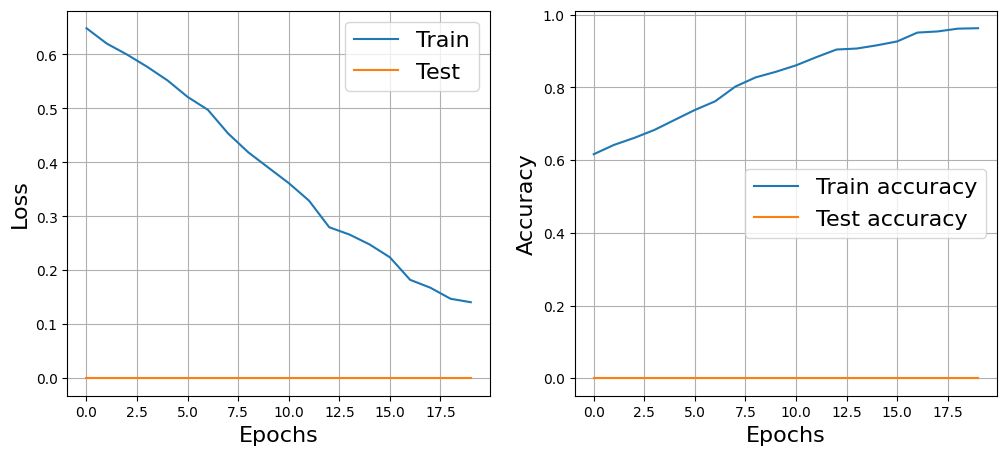

In [23]:
network = l.NeuralNetwork([
    l.Linear(SHAPE**2, 256), l.ReLU(),
    l.Linear(256, 2)
])
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, LEARNING_RATE, loss=l.NLLLoss())

In [57]:
def train_tourch(network, epochs, learning_rate, loss):    
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    for epoch in range(epochs):
        start_time = time.time()
        losses = []
        accuracies = []
        for X, y in train_loader:
            X = X.view(X.shape[0], -1)
            y = y
    
            prediction = network.forward(X).view(-1)
            #print(prediction)
            #print(y)

            loss_batch = loss(prediction, y)
            #print(loss_batch.item())
            losses.append(loss_batch.item())
            loss_batch.backward()
            #print(loss_batch.item())
            #network.backward(loss_batch.item())
            #network.step(learning_rate)
            predicted = (prediction > 0.5).float()
            accuracies.append((predicted==y).numpy().mean())
        train_loss_epochs.append(np.mean(losses))
        train_accuracy_epochs.append(np.mean(accuracies))

        '''
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
        '''
        test_loss_epochs.append(0) #np.mean(losses))
        test_accuracy_epochs.append(0) #np.mean(accuracies))
            
        print(
            '\rEpoch [{0}/{1}] (Train/Test) NLL: {2:.3f}/{3:.3f}, Accuracy: {4:.3f}/{5:.3f} t: {6:.4f} s'.format(
                (epoch+1), epochs, train_loss_epochs[-1], test_loss_epochs[-1],
                train_accuracy_epochs[-1], test_accuracy_epochs[-1], (time.time() - start_time))
        )
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

    return train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs

Epoch [1/20] (Train/Test) NLL: -0.497/0.000, Accuracy: 0.467/0.000 t: 4.9313 s
Epoch [2/20] (Train/Test) NLL: -0.500/0.000, Accuracy: 0.467/0.000 t: 4.5091 s
Epoch [3/20] (Train/Test) NLL: -0.501/0.000, Accuracy: 0.467/0.000 t: 4.4760 s
Epoch [4/20] (Train/Test) NLL: -0.502/0.000, Accuracy: 0.466/0.000 t: 4.4998 s
Epoch [5/20] (Train/Test) NLL: -0.499/0.000, Accuracy: 0.466/0.000 t: 4.4590 s
Epoch [6/20] (Train/Test) NLL: -0.504/0.000, Accuracy: 0.467/0.000 t: 4.5150 s
Epoch [7/20] (Train/Test) NLL: -0.500/0.000, Accuracy: 0.467/0.000 t: 4.4678 s
Epoch [8/20] (Train/Test) NLL: -0.501/0.000, Accuracy: 0.466/0.000 t: 4.5174 s
Epoch [9/20] (Train/Test) NLL: -0.499/0.000, Accuracy: 0.467/0.000 t: 4.5242 s
Epoch [10/20] (Train/Test) NLL: -0.497/0.000, Accuracy: 0.467/0.000 t: 4.5205 s
Epoch [11/20] (Train/Test) NLL: -0.502/0.000, Accuracy: 0.466/0.000 t: 4.5105 s
Epoch [12/20] (Train/Test) NLL: -0.500/0.000, Accuracy: 0.467/0.000 t: 4.4575 s
Epoch [13/20] (Train/Test) NLL: -0.500/0.000, Acc

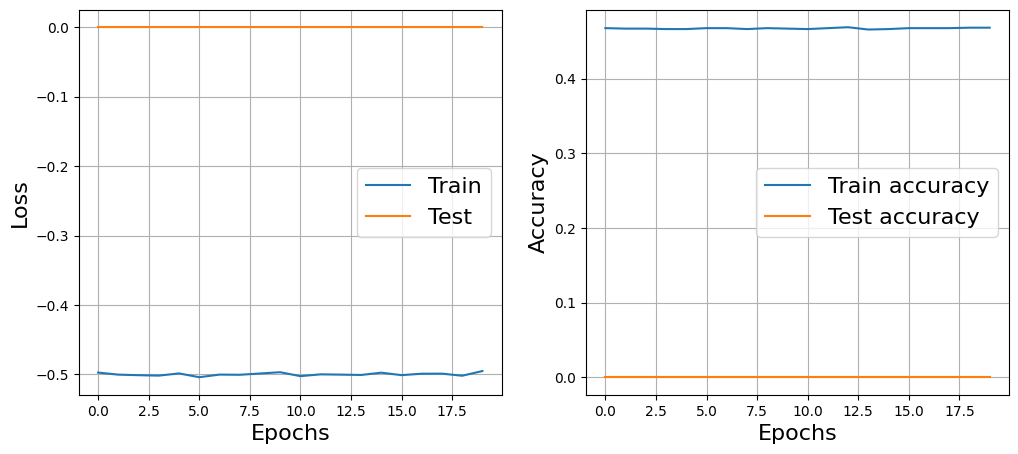

In [58]:
network_t = nn.Sequential(
    nn.Linear(SHAPE**2 , 256), nn.ReLU(),
    nn.Linear(256, 1), nn.Sigmoid()
)
tr_r, ts_r, tr_ac_r, ts_ac_r = train_tourch(network_t, 20, LEARNING_RATE, loss=nn.NLLLoss())

In [84]:
# Define the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(SHAPE**2, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, SHAPE**2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [91]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(SHAPE**2 , 512), nn.ReLU(),
            nn.Linear(512, 2), nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, SHAPE**2)
        #x = F.relu(self.fc1(x))
        x = self.fc_layers(x)
        return x

In [92]:
device = DEVICE
model = Net().to(device)
print(model) 

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / len(labels)

Net(
  (fc_layers): Sequential(
    (0): Linear(in_features=16384, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
    (3): Sigmoid()
  )
)


In [95]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()

    running_loss = []
    running_acc = []
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())
        running_acc.append(accuracy(outputs, labels))
    print(f'Epoch {epoch}, Loss: {np.mean(running_loss):.4f}, Accuracy: {np.mean(running_acc):.4f}')

In [94]:
for epoch in range(1, EPOCH + 1):
    train(model, device, train_loader, criterion, optimizer, epoch) # Train the model

Epoch 1, Loss: 0.6607, Accuracy: 0.6000
Epoch 2, Loss: 0.6461, Accuracy: 0.6244
Epoch 3, Loss: 0.6397, Accuracy: 0.6428
Epoch 4, Loss: 0.6347, Accuracy: 0.6529
Epoch 5, Loss: 0.6310, Accuracy: 0.6533
Epoch 6, Loss: 0.6263, Accuracy: 0.6633
Epoch 7, Loss: 0.6208, Accuracy: 0.6745
Epoch 8, Loss: 0.6155, Accuracy: 0.6769
Epoch 9, Loss: 0.6113, Accuracy: 0.6905
Epoch 10, Loss: 0.6054, Accuracy: 0.6997


## Как в лекции

In [49]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [50]:
model = CNN()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [53]:
def save_checkpoint(state, filename='checkpoint.pth'):
    """Сохранение состояния модели"""
    torch.save(state, filename)


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_val_acc = 0.0
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
        
        #writer.add_scalar('Loss/train', train_loss, epoch)
        #writer.add_scalar('Accuracy/train', train_acc, epoch)
        #writer.add_scalar('Loss/val', val_loss, epoch)
        #writer.add_scalar('Accuracy/val', val_acc, epoch)
        

        if val_acc > best_val_acc:
            print(f'Validation accuracy improved from {best_val_acc:.4f} to {val_acc:.4f}. Saving model...')
            best_val_acc = val_acc
            
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                'accuracy': val_acc
            }
            save_checkpoint(checkpoint, 'cnn_best_checkpoint.pth')
            
    
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    loss = running_loss / len(loader)
    accuracy = correct / total
    return loss, accuracy


In [54]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Loss: 50.6102, Accuracy: 0.4927, Val Loss: 48.5392, Val Accuracy: 0.5171
Validation accuracy improved from 0.0000 to 0.5171. Saving model...


 40%|██████████████████                           | 2/5 [00:14<00:22,  7.37s/it]

Epoch [2/5], Loss: 50.4253, Accuracy: 0.4951, Val Loss: 48.5392, Val Accuracy: 0.5171


 60%|███████████████████████████                  | 3/5 [00:21<00:14,  7.23s/it]

Epoch [3/5], Loss: 50.4253, Accuracy: 0.4951, Val Loss: 48.5392, Val Accuracy: 0.5171


 80%|████████████████████████████████████         | 4/5 [00:29<00:07,  7.18s/it]

Epoch [4/5], Loss: 50.6472, Accuracy: 0.4951, Val Loss: 48.5392, Val Accuracy: 0.5171


100%|█████████████████████████████████████████████| 5/5 [00:36<00:00,  7.22s/it]

Epoch [5/5], Loss: 50.6472, Accuracy: 0.4951, Val Loss: 48.5392, Val Accuracy: 0.5171
